In [16]:
import os, sys, time, copy
import random
import numpy as np
import matplotlib.pyplot as plt

import multiprocessing
from tqdm import tqdm


import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ical.ICaNa', 'ical.ICaK', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa']

# t_span = (0, 5000)
# t_eval = np.linspace(0, t_span[1], 10000)  

### Create Voltage Protocol

In [3]:
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()

VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )  # <- why?? vo
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=200)) # ramp step
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=100) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=500) )
# VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=60, voltage_end=-80, duration=200)) # ramp step

vhold = VC_protocol.steps[0].voltage

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

The protocol is 1320 ms


In [4]:
start_time = time.time()

model, p, s = myokit.load("../mmt-model-files/ohara-cipa-v1-2017_VC.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  
params = {         
    'cell.mode': cell_types['Mid-myocardial'],    
}
sim.set_simulation_params(params)
y0 = sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(VC_protocol.get_voltage_change_endpoints()[-1], log_times=None, extra_log=['membrane.i_ion'] + extra_log)

sol1 = {}
times1 = d['engine.time']
sol1["Voltage"] = VC_protocol.get_voltage_clamp_protocol(d['engine.time'])
sol1["I_total"] = d['membrane.i_ion']
sol1["I_Na"] = d['ina.INa']
sol1["I_Kr"] = d['ikr.IKr']
sol1["I_Ks"] = d['iks.IKs']
sol1["I_To"] = d['ito.Ito']
sol1["I_CaL"] = d['ical.ICaL']
sol1["I_K1"] = d['ik1.IK1']
sol1["I_NaL"] = d['inal.INaL']

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.9309608936309814 seconds ---


In [5]:
start_time = time.time()

model, p, s = myokit.load("../mmt-model-files/ohara-cipa-v1-2017_JK-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.4936747550964355 seconds ---


In [6]:
start_time = time.time()
       
params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  
    
    'ina.gNa' : 75.0,   
    'inal.gNaL' : 0.0075 * 2.661,  
    'ito.gto' : 0.02,
    'ical.PCa' : 0.0001 * 1.007,
    'ikr.gKr' : 4.65854545454545618e-2, # [mS/uF]
    'iks.gKs' : 0.0034 * 1.87,
    'ik1.gK1' : 0.1908 * 1.698,
    'inaca.gNaCa' : 0.0008,
    'inak.PNaK' : 30,
    'ikb.gKb' : 0.003,
    'inab.PNab' : 3.75e-10,
    'icab.PCab' : 2.5e-8,
    'ipca.GpCa' : 0.0005,

    'ina.g_adj' : 1,  
    'inal.g_adj' : 1,
    'ito.g_adj' : 4,
    'ical.g_adj' : 2.5,
    'ikr.g_adj' : 0.8,
    'iks.g_adj' : 1,
    'ik1.g_adj' : 1.3,
    'inaca.g_adj' : 1.4,
    'inak.g_adj' : 0.7,
    'ikb.g_adj' : 1,
    'inab.g_adj' : 1,
    'icab.g_adj' : 1,
    'ipca.g_adj' : 1, 
}
sim.set_simulation_params(params)

# sim.set_initial_values([-88] + y0)
sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(VC_protocol.get_voltage_change_endpoints()[-1], log_times=None , extra_log=['membrane.VC', 'membrane.i_ion'] + extra_log)

sol2 = {}
times2 = d['engine.time']
sol2["Voltage"] = d['membrane.VC']
sol2["I_total"] = d['membrane.i_ion']
sol2["I_Na"] = sim.current_response_info.get_current(['INa'])
sol2["I_Kr"] = sim.current_response_info.get_current(['IKr'])
sol2["I_Ks"] = sim.current_response_info.get_current(['IKs'])
sol2["I_To"] = sim.current_response_info.get_current(['Ito'])
sol2["I_CaL"] = sim.current_response_info.get_current(['ICaL'])
sol2["I_K1"] = sim.current_response_info.get_current(['IK1'])
sol2["I_NaL"] = sim.current_response_info.get_current(['INaL'])

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.4080331325531006 seconds ---


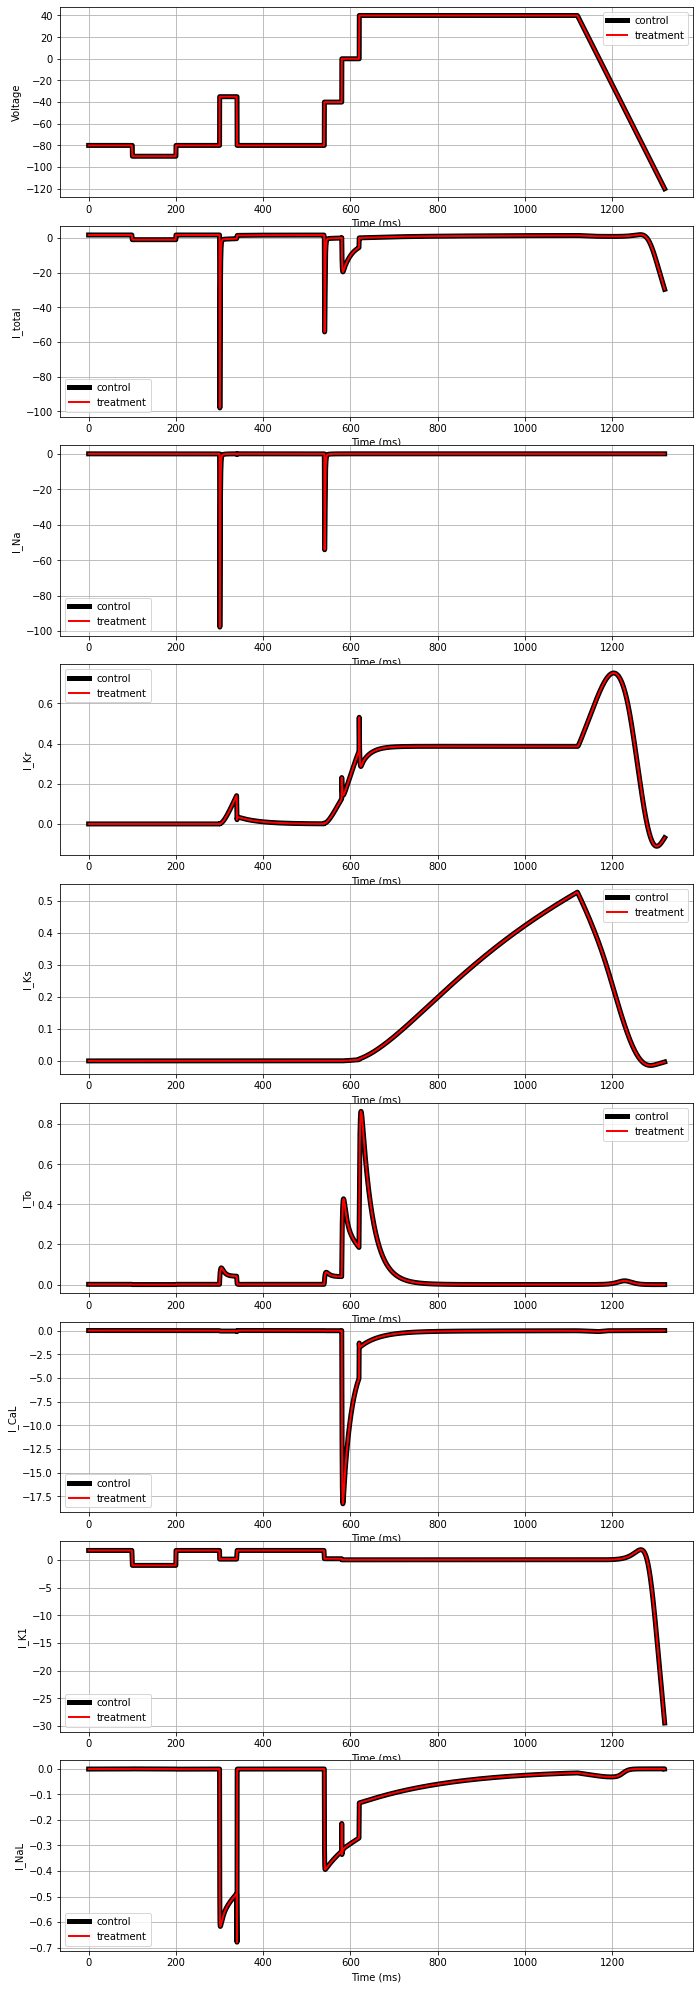

In [7]:
'''
Plot
'''
fig, ax = plt.subplots(len(sol1),1, figsize=(10,30))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol1.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times1, values, label='control', color='k', linewidth=5)     
    ax[i].plot( times2, sol2[name], label='treatment', color='r', linewidth=2)    
    ax[i].legend()
    ax[i].grid()

# ax[-1].set_ylim(-5, 5)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
# fig.savefig(os.path.join('Results', "C.jpg"), dpi=100)

In [17]:
def gen_dataset(self, gen_params, datasetNo=1):
    '''
    type = 'AP' or 'I" 
    params = {
        'times': 1,                    
        'log_li' : [],
        'nData' : 10000,                         
        'dataset_dir' :   './dataset',
        'data_file_name' :  'current',
        'scale' : 2,
    }  
    '''
    random.seed(datasetNo * 84)
    np.random.seed(datasetNo * 86)

    print("-----Dataset%d generation starts.-----"%(datasetNo))

    d = None              
    result_li = []
    param_li = []
    current_nData = 0

    simulation_error_count = 0
    with tqdm(total = gen_params['nData']) as pbar: 
        while (current_nData < gen_params['nData']):                
            g_adj = np.random.uniform(0, 1, 7)                      
            if current_nData==0 and datasetNo==1:
                g_adj = np.ones(7)                 

            Gfc = {                    
                'ina.g_adj' : g_adj[0],
                'inal.g_adj' : g_adj[1],
                'ito.g_adj' : g_adj[2],
                'ical.g_adj' : g_adj[3],
                'ikr.g_adj' : g_adj[4],
                'iks.g_adj' : g_adj[5],
                'ik1.g_adj' : g_adj[6],
                # 'if.g_adj' : g_fc[7]    
            } 
            self.set_simulation_params(Gfc)                
            # log_li = ['membrane.V']
            # if len(log_li)>0:
            #     log_li = gen_params['log_li']
            try :
                d = self.simulate( gen_params['times'], extra_log=gen_params['log_li'])                           
                temp = []
                for log in log_li :                                              
                    temp.append(d[log]) ###################
                result_li.append( np.array(temp, dtype=np.float32) ) 
                param_li.append( g_adj )
                current_nData+=1                    
            except :
                simulation_error_count += 1
#                 print("There is a simulation error.")
                continue
            pbar.update(1) 

    result_li = np.array(result_li, dtype=np.float32)        
    param_li = np.array(param_li, dtype=np.float32)        

    np.save(os.path.join(gen_params['dataset_dir'], 'times'), d['engine.time'].astype(np.float32) )    #######################3
    np.save(os.path.join(gen_params['dataset_dir'], 'voltage_protocol'), d['membrane.V'].astype(np.float32) )     #########################
    np.save(os.path.join(gen_params['dataset_dir'], "%s%d"%(gen_params['data_file_name'], datasetNo) ), result_li)
    np.save(os.path.join(gen_params['dataset_dir'], 'parameter%d'%(datasetNo) ), param_li )

    result_li = []
    param_li = []

    print("=====Dataset%d generation End.===== %d simulation errors occured.====="%(datasetNo, simulation_error_count))       

In [20]:
if __name__=='__main__':
    start_time = time.time()    
    nCPU = os.cpu_count()          
    print("The number of process :", nCPU )   
   

    multi = False
    
    params = {
        'times': 1,                    
        'log_li' : ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1'],
        'nData' : 10000,                         
        'dataset_dir' : './dataset',
        'data_file_name' :  'current',
        'scale' : 1,
    }  
    
    startNo = 1
    nDataset = 1      
    datasetNo_li = list(range(startNo, startNo+nDataset))  # Core 수만큼  [1,2,3,4,5,6,7,8,9,10]    
    print(datasetNo_li)          
    
    try:
        if not os.path.exists(params['dataset_dir']):
            os.makedirs(params['dataset_dir'])
            print('"%s" has been created.'%(params['dataset_dir']))
        else:
            print("The folder already exists.")
    except OSError:
        print('Error: create_folder(). : ' + params['dataset_dir'])
         
    if multi :            
        pool = multiprocessing.Pool(processes=nDataset )
        func = partial(gen_dataset, params)
        pool.map(func, datasetNo_li)
        pool.close()
        pool.join()
    else:
        for No in datasetNo_li :
            gen_dataset(params, No)
        
    print("Dataset has been generated.")
    
    print("--- %s seconds ---"%(time.time()-start_time))

    
    # 

    # # Set parameter transformation
    # transform_to_model_param = log_transform_to_model_param       # return np.exp(out)
    # transform_from_model_param = log_transform_from_model_param   # return np.log(out)
    
    # logprior = LogPrior(transform_to_model_param, transform_from_model_param)
      
    # p = logprior.sample_without_inv_transform()
    # print(p)
    
    # print(logprior.rmax)
    # print(logprior.rmin)
    # print(5e5)

 

The number of process : 72
[1]
The folder already exists.
-----Dataset1 generation starts.-----


TypeError: 'int' object is not subscriptable